# Modeling Short Time Series with Prior Knowledge in PyMC

In this notebook I want to reproduce in [PyMC](https://github.com/pymc-devs/pymc) the methodology described in the amazing blog post [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge) by [Tim Radtke](https://minimizeregret.com/about/) to forecast short time series using *bayesian transfer learning*. The main idea is to transfer information (e.g. long term seasonality) from a long time series to a short time series via prior distributions. Tim's blog post treats a very concrete example where all the concepts become very concrete. The challenge of the example is to generate long term forecast for a short time series of bike sales data. Specifically, the input sales data consists of three months of daily data and the objective is to generate at least a two years forecast. In general this is very hard to to with commonly available methods (as we will show below) due the fact we do not have enough historical data to capture seasonal patterns. For this concrete example, we do expect to have a strong yearly seasonal pattern as bike sales are usually much higher during summer than in winter. Hence, we could use temperature as a proxy for this seasonal pattern. However, as mentioned above, we can not simply try to use such data in a model with just 3 months of daily data ... ¯\\_(ツ)_/¯ ... **Here s the elegant trick**: First, fit a model on long past historical temperature data through [Fourier modes](https://en.wikipedia.org/wiki/Fourier_series) (as in Facebook's [Prophet](https://facebook.github.io/prophet/) model). Then use the posterior means and standard deviations of each Fourier mode as the prior distribution for the sales short time series $y_t$. For the later model we use a [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) as the likelihood function (as we are modeling count data, i.e. the number of sales) and model the mean $\mu_t$ through three main components:

1. A *seasonal component* which consists of Fourier modes with the specified priors, dummy variables to model the weekly seasonality and a mild trend component.
2. We use an autoregressive term $\mu_{t -1}$ on the mean itself.
3. An autoregressive term $y_{t - 1}$ from the input sales data.

By combining the the long term seasonality learned in the temperature model in this way we can adapt it to match the scale of the sales data. We will describe the full model specification below.

 I was fortunate to see [Tim's talk](https://minimizeregret.com/post/2019/06/16/satrday-berlin-presentation/) about the subject back in 2019 during the [satRdays](https://berlin2019.satrdays.org/) Berlin conference (where I also gave a talk on [Remedies for Severe Class Imbalance](https://juanitorduz.github.io/class_imbalance/)). I remember listening to such great presentation ant thinking *Wow! This is a fantastic idea!* At that time I was not able to follow the modeling strategy 100%, but I kept the idea in mind. Since then, I have been faced a couple of times to the challenge of forecasting short time series where there is an expected seasonal pattern but not enough historical data. Of course, when there are many time series, the problem can be tackled using probabilistic forecasting as well (see for example [deepAR](https://arxiv.org/abs/1704.04110?context=stat.ML)). However, the strategy presented on Tim's blog post is very elegant and can serve situations where the number of time series is small (which is often the case in certain domains, e.g. marketing). Hence, I decided to try it out in PyMC! Moreover, while trying to reproduce this work I also learned some very useful things on the side:

- The particular models (which we describe below) to perform the transfer learning are very interesting (specially the local level model) and I can see similar variations being applicable in many real world problems.
- Learn to read [Stan](https://mc-stan.org/) code and understand how it works. This is because the code is provided in [R](https://www.r-project.org/) and the model is sampled using [Stan](https://mc-stan.org/). Please find the code of the blog post [here](https://github.com/timradtke/short-time-series) (kudos to Tim for sharing it and making the results fully reproducible!).
- Learn how to use [`aesara.scan`](https://aesara.readthedocs.io/en/latest/library/scan.html) to run loops efficiently inside a PyMC model. I must admit that learning how [`aesara.scan`](https://aesara.readthedocs.io/en/latest/library/scan.html)  works was not very easy and I really had to work a concrete example and carefully read documentation to get it work. I still need some more practice but I have a much better intuition now. I share some findings and extended explanations on an appendix at the end of this notebook.

I **strongly recommend to read Tim's original blog post** [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge) first to enjoy a clear understanding of the problem and the underlying ideas. The purpose of this notebook is mainly to reproduce his results (and the details behind the PyMC code) and not to give a detailed explanation of the model, specially the remarkable prior distributions analysis done by Tim. In addition, the original post was motivated by the short post [Fitting models to short time series](https://robjhyndman.com/hyndsight/short-time-series/) by [Rob J Hyndman](https://robjhyndman.com/).

*For the experienced readers:* if you have know a better way to re-write or optimize this PyMC implementation I would love to hear about it. The time it takes to sample is comparable to the time it takes to run the Stan code through R.

**Data Sources:**
- *Sales Data:* Publicly available [Citi Bike](https://www.citibikenyc.com/) data from station 360 in New York City, see [here](https://s3.amazonaws.com/tripdata/index.html).
- *Temperature Data:*  Available on Kaggle, see [here](https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data).

## Prepare Notebook

In [1]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:86: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Read Data

We get the data from the original blog post repository [github.com/timradtke/short-time-series](https://github.com/timradtke/short-time-series). For the purpose of this notebook, I already combined (outer join on date) the sales and temperature data.

In [2]:
raw_df = pd.read_csv("../data/sales.csv", parse_dates=["date"])

raw_df.head()

date 
 sales 
 temp 
 
 
 
 
 0 
 2013-07-01 
 57.0 
 303.0 
 
 
 1 
 2013-07-02 
 58.0 
 298.0 
 
 
 2 
 2013-07-03 
 53.0 
 301.0 
 
 
 3 
 2013-07-04 
 36.0 
 302.0 
 
 
 4 
 2013-07-05 
 29.0 
 305.0

## EDA

Let us start by  looking into the data.

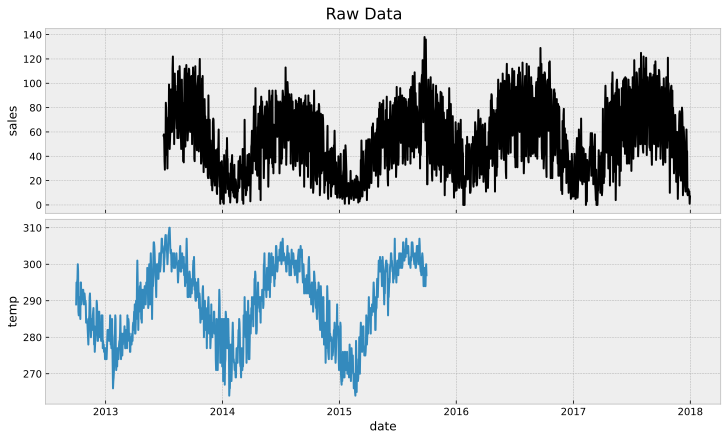

In [3]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="sales", data=raw_df, color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df, color="C0", ax=ax[1])
fig.suptitle("Raw Data", fontsize=16);

The first thing we observe is that we long data for both sales and temperature. Note however that our assumption is that we just have 3 months of historical sales data. The rest of the sales data is used as a "test set". On the other hand we do use all the available temperature data since the main idea s to have a predictor which is available in the future at prediction time (this could be the temperature forecast in real cases). Next, let us look at the sales data when both of them are not null:

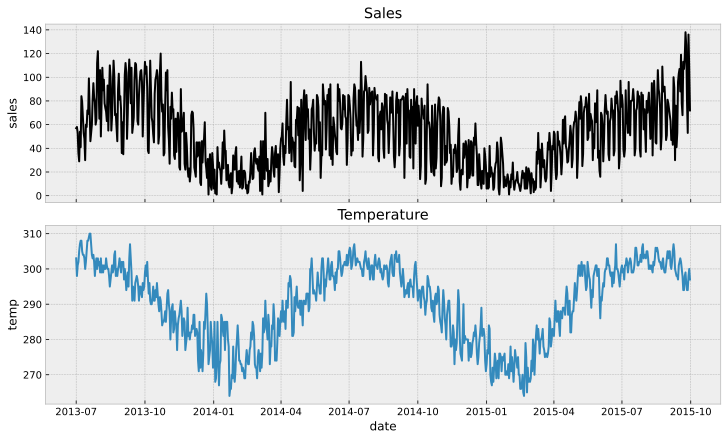

In [4]:
mask = "sales.notnull() and temp.notnull()"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="sales", data=raw_df.query(mask), color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df.query(mask), color="C0", ax=ax[1])
ax[0].set(title="Sales")
ax[1].set(title="Temperature");

We see a strong yearly seasonal pattern both variables. Now we move intro the data preparation step.

## Data Preparation

Let us set the start and end date of the training set for the sales model.

In [5]:
start_date = pd.to_datetime("2013-07-01")
train_test_date = pd.to_datetime("'2013-10-15'")

print(f"Training Set Length: {(train_test_date - start_date).days} days")

Training Set Length: 106 days


Now we split the data accordingly. In the process we also add two features:
1. We scale the temperature data
2. We create a trend component.

Please refer to the original blog post for a detailed explanation behind the motivation of these transformations. In a nutshell, we scale the temperature data as we are interested in relative values (so we subtract the minimum) and the trend is something we expect to be present in the long ter forecast, see below (again, the scales is not important).

In [6]:
# data points before the start of the training set
n_init = raw_df.sort_values("date").query("date < '2013-07-01'").shape[0]

df = (
    raw_df.query("temp.notnull()")
    .sort_values("date")
    .reset_index(drop=True)
    .eval(
        """
        temp_scaled = temp - temp.min()
        trend = (sales.index - @n_init + 1) / 365.25
    """
    )
)


df_train = df.query("date < @train_test_date & sales.notnull()")
df_test = df.query("date >= @train_test_date")

n_train = df_train.shape[0]
n_test = df_test.shape[0]
n = n_test + n_train

Let's visualize the sales model training set.

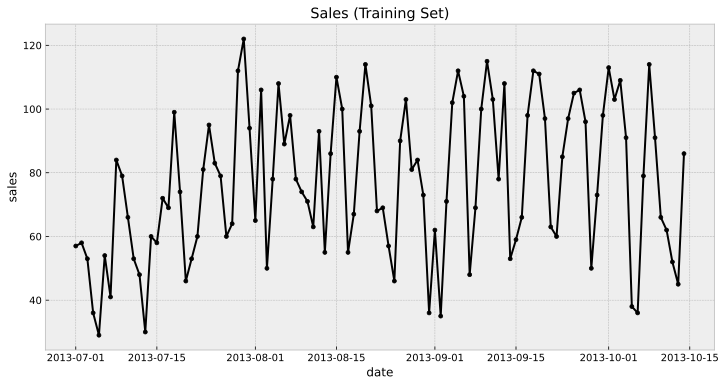

In [7]:
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    color="black",
    marker="o",
    markersize=4,
    markeredgecolor="black",
    ax=ax,
)
ax.set(title="Sales (Training Set)");

We see a clearly weekly pattern and a mild positive trend. Finally we plot the train and test split.

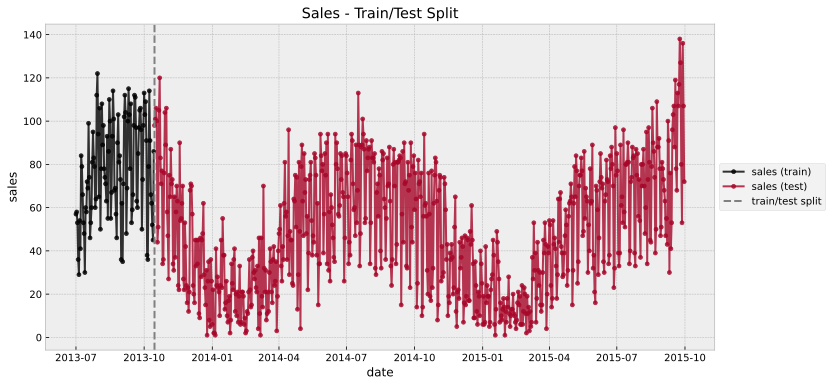

In [8]:
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="sales",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Sales - Train/Test Split");

## Temperature Model

Now that we are more familiar with the data we proceed to build the temperature model as described in the original blog post: We fit a Poisson regression (temperature is in Farenheit, so are integers) where the mean is modeled using [Fourier modes](https://en.wikipedia.org/wiki/Fourier_series) and and intercept. Note we use the complete set of available temperature values. Mathematically,

\begin{align*}
\text{temp\_scaled}_{t} & \sim \text{Poisson}(\mu_{t}) \\
\log(\mu_{t}) & = a + \sum_{k=1}^{K=6} b_{k}\sin\left(\frac{2\pi k t}{m}\right) + \tilde{b}_{k}\cos\left(\frac{2\pi k t}{m}\right), \quad m = 365.25 \\
a & \sim \text{Normal}(0, 1) \\
b_{k}, \tilde{b}_{k} & \sim \text{Normal}(0, 1)
\end{align*}

In [9]:
# We extract useful features.
date = df["date"]
temp_scaled = df["temp_scaled"]
trend = df["trend"]
sales = df["sales"]
# We extract the day of week for the sales model below.
dayofweek_idx, dayofweek = df["date"].dt.dayofweek.factorize()

We generate the Fourier modes as described in [Air passengers - Prophet-like model](https://www.pymc.io/projects/examples/en/latest/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html).

In [10]:
periods = df["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

Now we are ready to define the model.

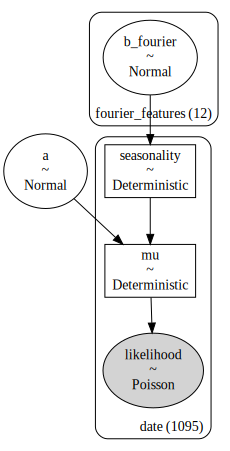

In [11]:
coords = {
    "date": date,
    "fourier_features": np.arange(2 * n_order),
}

with pm.Model(coords=coords) as temp_model:
    
    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=1)
    ## seasonality
    b_fourier = pm.Normal(name="b_fourier", mu=0, sigma=1, dims="fourier_features")
    
    # --- model parametrization ---
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.T), dims="date"
    )
    mu = pm.Deterministic(name="mu", var=a + seasonality, dims="date")

    # --- likelihood ---
    pm.Poisson("likelihood", mu=pm.math.exp(mu), observed=temp_scaled, dims="date")

pm.model_to_graphviz(temp_model)

Next we run some prior predictive checks.

In [12]:
with temp_model:
    temp_prior_predictive = pm.sample_prior_predictive(samples=1000)

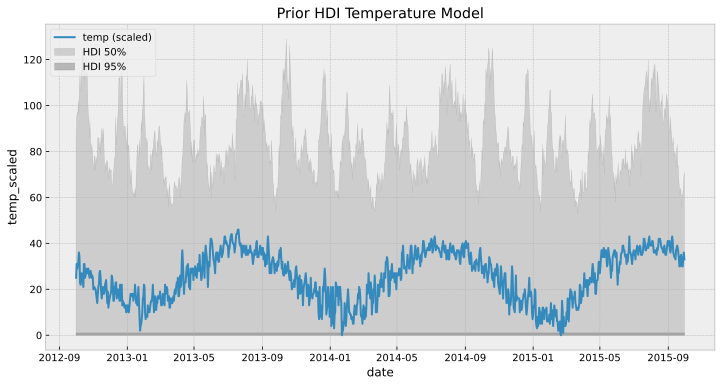

In [13]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Temperature Model");

Looks the values are feasible and not very constraining. Hence, we proceed to fit the model.

In [14]:
with temp_model:
    temp_idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.9, draws=4000, chains=4
    )
    temp_posterior_predictive = pm.sample_posterior_predictive(trace=temp_idata)

Compiling...
Compilation time =  0:00:04.759226
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:03.783735
Transforming variables...
Transformation time =  0:00:00.166089
Computing Log Likelihood...
Log Likelihood time =  0:00:01.204898


100.00% [16000/16000 00:02<00:00]

Let's see the summary and plot the trace.

In [15]:
az.summary(data=temp_idata, var_names=["a", "b_fourier"])

mean 
 sd 
 hdi_3% 
 hdi_97% 
 mcse_mean 
 mcse_sd 
 ess_bulk 
 ess_tail 
 r_hat 
 
 
 
 
 a 
 3.146 
 0.006 
 3.134 
 3.159 
 0.0 
 0.0 
 20969.0 
 13624.0 
 1.0 
 
 
 b_fourier[0] 
 -0.248 
 0.009 
 -0.265 
 -0.231 
 0.0 
 0.0 
 24786.0 
 12867.0 
 1.0 
 
 
 b_fourier[1] 
 -0.547 
 0.009 
 -0.566 
 -0.530 
 0.0 
 0.0 
 18472.0 
 13477.0 
 1.0 
 
 
 b_fourier[2] 
 -0.122 
 0.010 
 -0.140 
 -0.104 
 0.0 
 0.0 
 19721.0 
 12822.0 
 1.0 
 
 
 b_fourier[3] 
 -0.049 
 0.009 
 -0.066 
 -0.031 
 0.0 
 0.0 
 20019.0 
 13006.0 
 1.0 
 
 
 b_fourier[4] 
 -0.046 
 0.009 
 -0.064 
 -0.029 
 0.0 
 0.0 
 19058.0 
 13353.0 
 1.0 
 
 
 b_fourier[5] 
 0.047 
 0.009 
 0.030 
 0.065 
 0.0 
 0.0 
 19848.0 
 13078.0 
 1.0 
 
 
 b_fourier[6] 
 -0.005 
 0.009 
 -0.022 
 0.013 
 0.0 
 0.0 
 19416.0 
 13460.0 
 1.0 
 
 
 b_fourier[7] 
 0.046 
 0.009 
 0.028 
 0.063 
 0.0 
 0.0 
 19233.0 
 13051.0 
 1.0 
 
 
 b_fourier[8] 
 -0.000 
 0.009 
 -0.018 
 0.017 
 0.0 
 0.0 
 18230.0 
 13328.0 
 1.0 
 
 
 b_fourier[9] 
 0.016 
 0.009 
 -0.001 
 0.034 
 0.0 
 0.0 
 20411.0 
 12549.0 
 1.0 
 
 
 b_fourier[10] 
 0.007 
 0.009 
 -0.009 
 0.024 
 0.0 
 0.0 
 21447.0 
 13222.0 
 1.0 
 
 
 b_fourier[11] 
 0.017 
 0.009 
 0.001 
 0.034 
 0.0 
 0.0 
 21141.0 
 12520.0 
 1.0

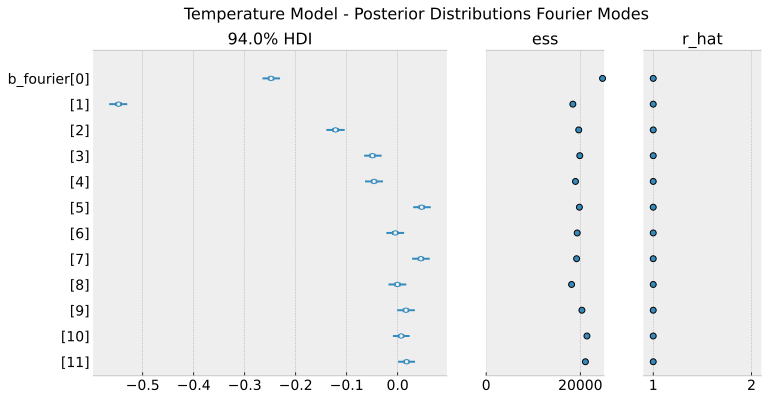

In [16]:
ax = az.plot_forest(
    kind="forestplot",
    data=temp_idata,
    var_names=["b_fourier"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(12, 6),
)
plt.gcf().suptitle(
    "Temperature Model - Posterior Distributions Fourier Modes", fontsize=16
);

These distributions match the ones obtained in the original blog post (see figure *Posterior linear combination of the Fourier terms for the temperature model*). To end this section we simply plot the posterior predictive distribution.

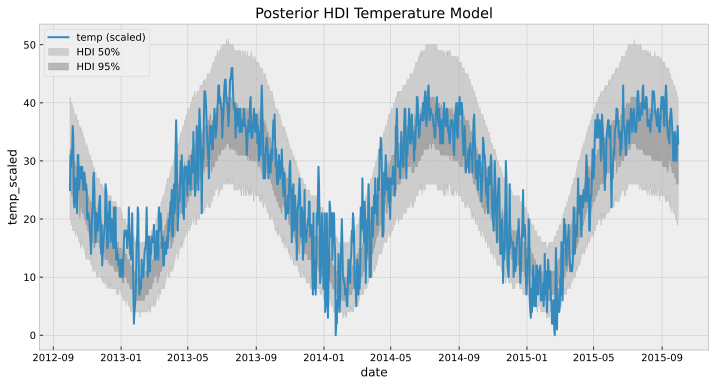

In [17]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Temperature Model");

## Sales Model

Now we come to the core of this notebook: build the sales model using the output of the temperature model. To begin with, we define extract similar features as above but *just for the training period*.

In [18]:
date_train = df_train["date"]
sales_train = df_train["sales"]
trend_train = df_train["trend"]
dayofweek_idx_train, dayofweek_train = df_train["date"].dt.dayofweek.factorize()

periods_train = df_train["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features_train = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods_train * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

Next we extract the means and standard deviations of the learned Fourier modes posterior distributions.

In [19]:
temp_model_summary = az.summary(data=temp_idata, var_names=["b_fourier"])
fourier_loc = temp_model_summary["mean"]
fourier_sd = temp_model_summary["sd"]

Let's now be explicit about the model structure:

\begin{align*}
\text{sales}_{t} & \sim \text{NegativeBinomial}(\mu_{t}, \alpha) \\
\mu_{t} & = (1 - \delta - \eta) \lambda_{t} + \delta \mu_{t-1} + \eta \: \text{sales}_{t-1}, \quad 0 \leq \delta \leq 1, 0 \leq \eta \leq 1 - \delta  \\
\log(\lambda_{t}) & = b_{\text{trend}}\frac{t}{m} + \sum_{j=1}^{7}b_{\text{dow}, j}\text{dayofweek}_{t} + \sum_{k=1}^{K=6} b_{k}'\sin\left(\frac{2\pi k t}{m}\right) + \tilde{b}_{k}
'\cos\left(\frac{2\pi k t}{m}\right), \quad m = 365.25 \\
\alpha & = \frac{1}{\tilde{\alpha}^2} \\
\delta & \sim \text{Beta}(1, 10) \\
\eta & \sim \text{Gamma}(1, 10) \\
b_{\text{trend}} & \sim \text{Normal}(0.03, 0.02) \\
b_{\text{dow}, j} & \sim \text{Normal}(4, 2) \\
b_{k}' & \sim \text{Normal}(\text{E}[b_{k}], \sqrt{\text{Var}[b_{k}]}) \\
\tilde{b}_{k}' & \sim \text{Normal}(\text{E}[\tilde{b}_{k}], \sqrt{\text{Var}[\tilde{b}_{k}]}) \\
\tilde{\alpha} & \sim \text{Normal}(0, 0.5)
\end{align*}


In summary, we model the sales using a negative binomial likelihood. The mean $\mu_t$ of such distribution is modeled using three components: seasonality ($\lambda_t$), an autoregressive term on the latent mean ($\mu_{t - 1}$) and an autoregressive sales model. The seasonality component includes a linear trend, in-week seasonality via day of week indicator functions and long term seasonality modeled using Fourier modes. The key point to note is that the prior of such Fourier modes are actually determined by the posterior distribution obtained from the temperature model.

Now we write the model above in PyMC.

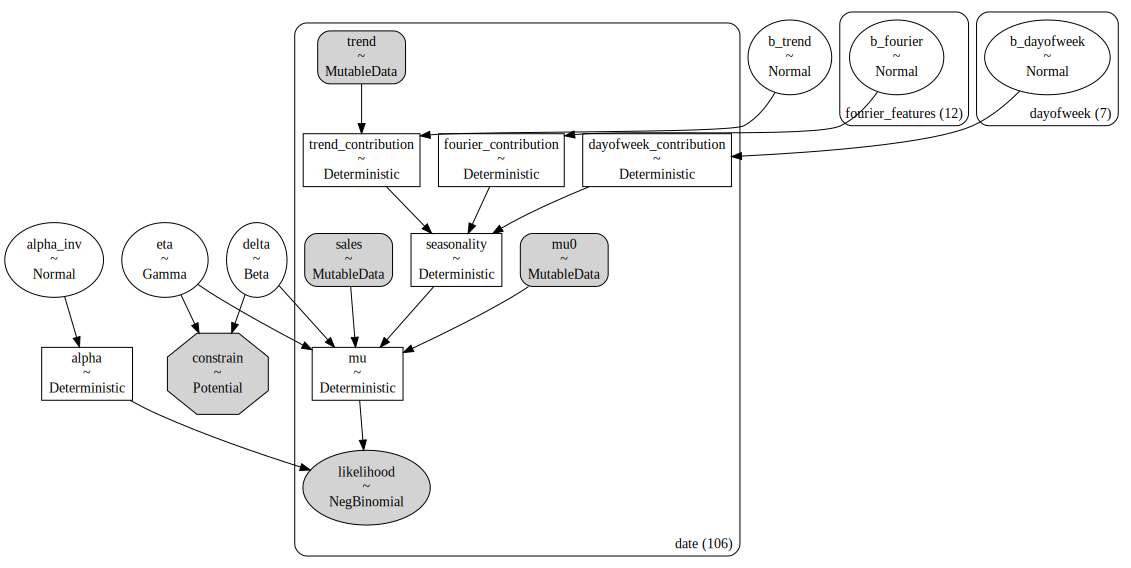

In [20]:
coords = {
    "fourier_features": np.arange(2 * n_order),
    "dayofweek": dayofweek_train,
}

with pm.Model(coords=coords) as sales_model:
    
    # --- data containers ---
    sales_model.add_coord(name="date", values=date_train, mutable=True)
    trend_data = pm.MutableData(name="trend", value=trend_train, dims="date")
    sales_data = pm.MutableData(name="sales", value=sales_train, dims="date")

    # --- priors ---
    delta = pm.Beta(name="delta", alpha=1, beta=10)
    eta = pm.Gamma(name="eta", alpha=0.5, beta=10)
    b_fourier = pm.Normal(
        name="b_fourier", mu=fourier_loc, sigma=fourier_sd, dims="fourier_features"
    )
    b_dayofweek = pm.Normal(name="b_dayofweek", mu=4, sigma=2, dims="dayofweek")
    b_trend = pm.Normal(name="b_trend", mu=0.03, sigma=0.02)
    alpha_inv = pm.Normal(name="alpha_inv", mu=0, sigma=0.5)

    # --- model parametrization ---
    ## parameters constraints
    pm.Potential(name="constrain", var=at.switch(eta > 1 - delta, -np.inf, 0))
    # transferred trend and seasonality
    fourier_contribution = pm.Deterministic(
        name="fourier_contribution",
        var=pm.math.dot(b_fourier, fourier_features_train.to_numpy().T),
        dims="date",
    )
    dayofweek_contribution = pm.Deterministic(
        name="dayofweek_contribution", var=b_dayofweek[dayofweek_idx_train], dims="date"
    )
    trend_contribution = pm.Deterministic(
        name="trend_contribution", var=b_trend * trend_data, dims="date"
    )
    seasonality = pm.Deterministic(
        name="seasonality",
        var=pymc.math.exp(
            fourier_contribution + dayofweek_contribution + trend_contribution
        ),
        dims="date",
    )
    ## damped dynamic mean
    mu0 = pm.MutableData(
        name="mu0", value=np.zeros(sales_data.shape.eval()[0]), dims="date"
    )
    mu0 = at.set_subtensor(mu0[0], sales_data[0])

    def one_step(seasonality_t, sales_tm1, mu_tm1, delta, eta):
        return (1 - delta - eta) * seasonality_t + delta * mu_tm1 + eta * sales_tm1

    outputs, _ = aesara.scan(
        fn=one_step,
        sequences=[
            dict(input=seasonality[1:], taps=[0]),
            dict(input=sales_data, taps=[-1]),
        ],
        outputs_info=dict(initial=mu0, taps=[-1]),
        non_sequences=[delta, eta],
        strict=True,
    )
    mu = pm.Deterministic(
        name="mu", var=at.set_subtensor(mu0[1:], outputs[:, 0]), dims="date"
    )
    alpha = pm.Deterministic(name="alpha", var=1 / pm.math.sqr(alpha_inv))

    # --- likelihood ---
    pm.NegativeBinomial(
        name="likelihood", alpha=alpha, mu=mu, observed=sales_data, dims="date"
    )

pm.model_to_graphviz(sales_model)

As always, is always good to run prior predictive checks before fitting the model.

In [21]:
with sales_model:
    sales_prior_predictive = pm.sample_prior_predictive(samples=1000)

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_97379/2852363265.py:2: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  sales_prior_predictive = pm.sample_prior_predictive(samples=1000)


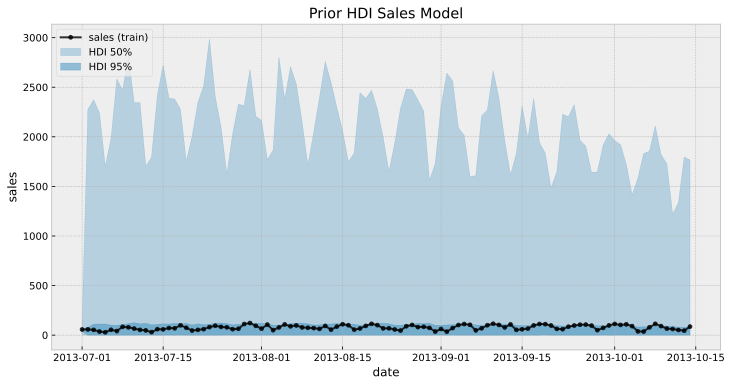

In [22]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
)
az.plot_hdi(
    x=date_train,
    y=sales_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date_train,
    y=sales_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Sales Model");


Overall, looks ok. Now we fit the model.

**Remark:** I was not able to use the `pymc.sampling_jax` samples for this model because of the scan operator ¯\\_(ツ)_/¯ .

In [23]:
with sales_model:
    sales_idata = pm.sample(target_accept=0.97, draws=4_000, chains=4)
    sales_posterior_predictive = pm.sample_posterior_predictive(trace=sales_idata)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, eta, b_fourier, b_dayofweek, b_trend, alpha_inv]
INFO:pymc:NUTS: [delta, eta, b_fourier, b_dayofweek, b_trend, alpha_inv]


100.00% [20000/20000 17:56<00:00 Sampling 4 chains, 0 divergences]

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 1101 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 1101 seconds.
/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_97379/3689318137.py:3: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  sales_posterior_predictive = pm.sample_posterior_predictive(trace=sales_idata)


100.00% [16000/16000 00:08<00:00]

We can now look into the posterior diagnostic and posterior distributions.

In [24]:
var_names = ["b_fourier", "b_dayofweek","b_trend", "delta", "eta", "alpha"]

In [25]:
az.summary(data=sales_idata, var_names=var_names)

mean 
 sd 
 hdi_3% 
 hdi_97% 
 mcse_mean 
 mcse_sd 
 ess_bulk 
 ess_tail 
 r_hat 
 
 
 
 
 b_fourier[0] 
 -0.250 
 0.009 
 -0.267 
 -0.233 
 0.000 
 0.000 
 18423.0 
 11279.0 
 1.0 
 
 
 b_fourier[1] 
 -0.545 
 0.009 
 -0.562 
 -0.528 
 0.000 
 0.000 
 17956.0 
 11734.0 
 1.0 
 
 
 b_fourier[2] 
 -0.122 
 0.010 
 -0.141 
 -0.104 
 0.000 
 0.000 
 20597.0 
 11769.0 
 1.0 
 
 
 b_fourier[3] 
 -0.052 
 0.009 
 -0.069 
 -0.035 
 0.000 
 0.000 
 19250.0 
 12459.0 
 1.0 
 
 
 b_fourier[4] 
 -0.044 
 0.009 
 -0.060 
 -0.027 
 0.000 
 0.000 
 16019.0 
 11818.0 
 1.0 
 
 
 b_fourier[5] 
 0.049 
 0.009 
 0.032 
 0.066 
 0.000 
 0.000 
 18712.0 
 12220.0 
 1.0 
 
 
 b_fourier[6] 
 -0.006 
 0.009 
 -0.023 
 0.010 
 0.000 
 0.000 
 18835.0 
 12163.0 
 1.0 
 
 
 b_fourier[7] 
 0.046 
 0.009 
 0.029 
 0.063 
 0.000 
 0.000 
 16716.0 
 11111.0 
 1.0 
 
 
 b_fourier[8] 
 -0.000 
 0.009 
 -0.017 
 0.016 
 0.000 
 0.000 
 17914.0 
 12005.0 
 1.0 
 
 
 b_fourier[9] 
 0.017 
 0.009 
 0.001 
 0.034 
 0.000 
 0.000 
 15545.0 
 12165.0 
 1.0 
 
 
 b_fourier[10] 
 0.006 
 0.009 
 -0.011 
 0.023 
 0.000 
 0.000 
 19463.0 
 12214.0 
 1.0 
 
 
 b_fourier[11] 
 0.014 
 0.009 
 -0.002 
 0.032 
 0.000 
 0.000 
 16982.0 
 11644.0 
 1.0 
 
 
 b_dayofweek[0] 
 4.627 
 0.254 
 4.169 
 5.112 
 0.005 
 0.004 
 2786.0 
 3250.0 
 1.0 
 
 
 b_dayofweek[1] 
 4.292 
 0.241 
 3.858 
 4.763 
 0.003 
 0.002 
 7113.0 
 5535.0 
 1.0 
 
 
 b_dayofweek[2] 
 3.935 
 0.461 
 3.231 
 4.556 
 0.009 
 0.006 
 7282.0 
 2862.0 
 1.0 
 
 
 b_dayofweek[3] 
 3.528 
 0.656 
 2.340 
 4.355 
 0.011 
 0.008 
 6393.0 
 3485.0 
 1.0 
 
 
 b_dayofweek[4] 
 3.246 
 0.883 
 1.473 
 4.205 
 0.017 
 0.012 
 3710.0 
 3827.0 
 1.0 
 
 
 b_dayofweek[5] 
 1.414 
 1.105 
 -0.643 
 3.176 
 0.012 
 0.009 
 8494.0 
 8827.0 
 1.0 
 
 
 b_dayofweek[6] 
 3.685 
 0.416 
 3.057 
 4.248 
 0.010 
 0.007 
 5247.0 
 2370.0 
 1.0 
 
 
 b_trend 
 0.032 
 0.020 
 -0.005 
 0.070 
 0.000 
 0.000 
 18385.0 
 11342.0 
 1.0 
 
 
 delta 
 0.386 
 0.144 
 0.110 
 0.645 
 0.003 
 0.002 
 2761.0 
 4262.0 
 1.0 
 
 
 eta 
 0.331 
 0.093 
 0.155 
 0.502 
 0.001 
 0.001 
 7054.0 
 8094.0 
 1.0 
 
 
 alpha 
 22.876 
 4.435 
 15.129 
 31.254 
 0.035 
 0.025 
 16097.0 
 11193.0 
 1.0

In [26]:
axes = az.plot_trace(
    data=sales_idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Sales Model - Trace", fontsize=16);

Now let's look into the in-sample posterior predictive distribution.

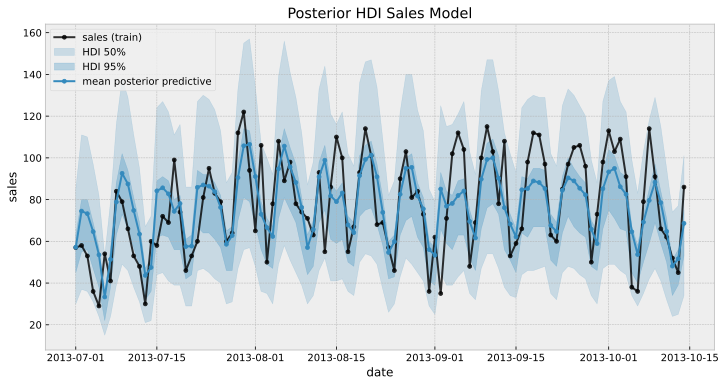

In [27]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
)
az.plot_hdi(
    x=date_train,
    y=sales_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=date_train,
    y=sales_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
sns.lineplot(
    x=date_train,
    y=sales_posterior_predictive.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1),
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Sales Model");


The results look good. Still, we can not see the long term effect (yet!).

**Remark:** In spite of the fact I tried to wrap almost all input variables as `pm.MutableData`, I was not able to run the `pm.sample_posterior_predictive` function to generate out-of-sample predictions. I think it has to do with the fact that the local level $\lambda_t$ depends on the previous days sales and the model specification does not allow for this dependency. Hence I do the predictions *by hand* (as in the original post). For the expert readers, please let me know if there is a way to modify the model to allow to get out-of-sample predictions through the `pm.sample_posterior_predictive` function.

In [28]:
# with sales_model:
#     pm.set_data(new_data={"sales": sales}, coords={"date": date})
#     sales_idata.extend(
#         other=pm.sample_posterior_predictive(
#             trace=sales_idata,
#             var_names=["likelihood"],
#             idata_kwargs={"coords": {"date": date}},
#         ),
#         join="right",
#     )


Now we are ready to generate the out-of-sample predictions. The idea is to generate the in-sample predictions for each component and then use the local level formula to generate out-of-sample predictions. Overall, it is quite straightforward but one just needs to be careful broadcasting over the sample dimensions.

In [29]:
posterior = sales_idata.posterior.stack(samples=("chain", "draw"))

n_samples = sales_idata.sample_stats.stack(samples=("chain", "draw")).samples.size

- Seasonal Component

In [30]:
seasonality_posterior = np.exp(
    posterior["b_trend"].to_numpy()[..., None] * trend[-n:][None, ...]
    + posterior["b_dayofweek"][dayofweek_idx[-n:]].T
    + np.tensordot(
        a=posterior["b_fourier"], b=fourier_features[-n:], axes=[[0], [1]]
    ).reshape(-1, n)
)

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_97379/2186306185.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  posterior["b_trend"].to_numpy()[..., None] * trend[-n:][None, ...]


- Posterior Predictive Distribution

In [31]:
sales_train_posterior = sales_posterior_predictive.posterior_predictive[
    "likelihood"
].stack(samples=("chain", "draw")).T

Now we are ready to generate the out-of-sample predictions. We start by generating data containers to fill in.

In [32]:
# container to store sales out-of-sample predictions
sales_posterior = np.zeros(shape=(n_samples, n))
sales_posterior[:, :n_train] = sales_train_posterior
# container to store out-of-sample predictions for the local level
mu_posterior = np.zeros(shape=(n_samples, n))
mu_posterior[:, :n_train] = posterior["mu"].T

Let's run the forward steps. Note this simply follows the model specification.

In [33]:
from tqdm.notebook import tqdm

for t in tqdm(range(n_train, n)):
    
    mu_posterior[:, t] = (
        ((1 - posterior["delta"] - posterior["eta"]) * seasonality_posterior[:, t])
        + (posterior["delta"] * mu_posterior[:, t - 1])
        + (posterior["eta"] * sales_posterior[:, t - 1])
    )

    likelihood = pm.NegativeBinomial.dist(
        name="posterior_sales", mu=mu_posterior[:, t], alpha=posterior["alpha"].to_numpy()
    )

    sales_posterior[:, t] = pm.draw(likelihood)

  0%|          | 0/716 [00:00<?, ?it/s]

Finally, we plot the predictions:

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_97379/2299276376.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  sales_posterior_hdi95 = az.hdi(sales_posterior, hdi_prob=0.95)
/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_97379/2299276376.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  sales_posterior_hdi50 = az.hdi(sales_posterior, hdi_prob=0.50)


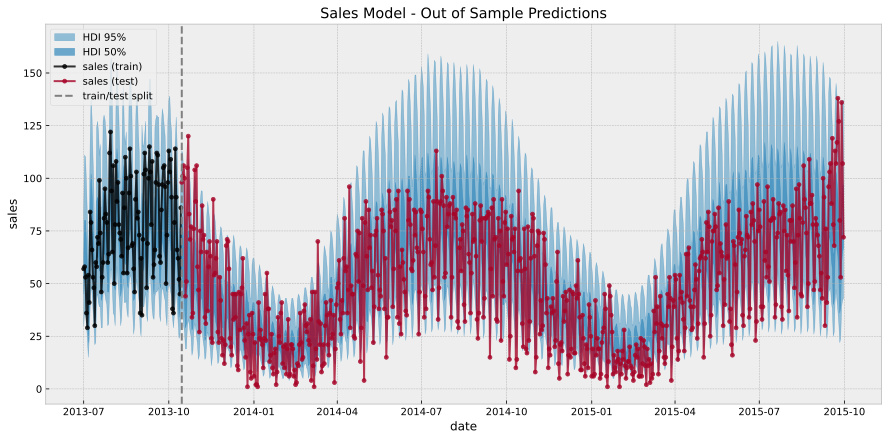

In [34]:
sales_posterior_hdi95 = az.hdi(sales_posterior, hdi_prob=0.95)
sales_posterior_hdi50 = az.hdi(sales_posterior, hdi_prob=0.50)

fig, ax = plt.subplots(figsize=(15, 7))

ax.fill_between(
    x=date[-n:],
    y1=sales_posterior_hdi95[:, 0],
    y2=sales_posterior_hdi95[:, 1],
    color="C0",
    label="HDI 95%",
    alpha=0.5,
)
ax.fill_between(
    x=date[-n:],
    y1=sales_posterior_hdi50[:, 0],
    y2=sales_posterior_hdi50[:, 1],
    color="C0",
    label="HDI 50%",
    alpha=0.7,
)
sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="sales",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="upper left")
ax.set(title="Sales Model - Out of Sample Predictions");


Yay! These predictions coincide with the original post [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge) by [Tim Radtke](https://minimizeregret.com/about/).

---

## Appendix: Scan Operator

In this section I simply present some code which helped me with the recursive step of the model defined using the [`aesara.scan`](https://aesara.readthedocs.io/en/latest/library/scan.html#aesara.scan) operator. The documentation page [`scan` - Looping in Aesara](https://aesara.readthedocs.io/en/latest/library/scan.html#scan-looping-in-aesara) is definitively a good starting point. It provides many examples and really tries to build some intuition. Nevertheless, to really unedrstand what is going on I had to try it myself! One particular example that helped me for this special use case was the one on [Multiple outputs, several taps values - Recurrent Neural Network with Scan](https://aesara.readthedocs.io/en/latest/library/scan.html#multiple-outputs-several-taps-values-recurrent-neural-network-with-scan). It provides exactly what I needed to implement the model! The idea is to explicitly define a function with the recursive step. In our case is simply:

In [35]:
def one_step(seasonality_t, sales_tm1, alpha_tm1, delta, eta):
    return (1 - delta - eta) * seasonality_t + delta * alpha_tm1 + eta * sales_tm1

We can run this function a couple of times for testing purposes:

In [43]:
mu0 = at.zeros(sales_data.shape.eval()[0])
mu0 = at.set_subtensor(mu0[0], sales_data[0])

for t in range(1, 20):
    step_output = one_step(seasonality[t], sales_data[t - 1], mu0[t - 1], delta, eta)
    mu0 = at.set_subtensor(mu0[t], step_output)

mu0.eval()

array([ 57.        ,  46.35528237,  77.36461315,  62.5669635 ,
       206.03102471,  60.91539446,  33.06142701,  38.64463848,
        48.69596301,  84.01553658,  67.9182289 , 214.42825066,
        67.67288707,  28.97307982,  42.4934078 ,  43.52909534,
        81.50515206,  68.25865339, 226.84680599,  77.11496603,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

Now, to compare the result let's run the scan code:

In [42]:
outputs, _ = aesara.scan(
    fn=one_step,
    sequences=[
        dict(input=seasonality[1:], taps=[-0]),
        dict(input=sales_data, taps=[-1]),
    ],
    outputs_info=dict(initial=mu0, taps=[-1]),
    non_sequences=[delta, eta],
    strict=True,
)

outputs.eval()

array([[46.35528237, 43.69484783, 51.44501065, ..., 32.10927093,
        32.10927093, 32.10927093],
       [77.36461315, 76.69969067, 78.63668906, ..., 73.80410715,
        73.80410715, 73.80410715],
       [62.5669635 , 62.4007794 , 62.88489346, ..., 61.67708614,
        61.67708614, 61.67708614],
       ...,
       [59.69723366, 59.69723366, 59.69723366, ..., 59.69723366,
        59.69723366, 59.69723366],
       [31.08826576, 31.08826576, 31.08826576, ..., 31.08826576,
        31.08826576, 31.08826576],
       [33.81745512, 33.81745512, 33.81745512, ..., 33.81745512,
        33.81745512, 33.81745512]])

Not that the *naïve* choice `output[-1]` is not the correct choice (of course I made this mistake 🙈). The correct choice is to use the `output[:, 0]` to get the last element of the output.

In [44]:
outputs[:, 0].eval()

array([ 46.35528237,  77.36461315,  62.5669635 , 206.03102471,
        60.91539446,  33.06142701,  38.64463848,  48.69596301,
        84.01553658,  67.9182289 , 214.42825066,  67.67288707,
        28.97307982,  42.4934078 ,  43.52909534,  81.50515206,
        68.25865339, 226.84680599,  77.11496603,  35.2410469 ,
        42.38604802,  43.98564908,  83.71434839,  75.03218001,
       223.71559658,  77.53323883,  38.71352354,  45.72966074,
        57.26447802,  96.33602292,  77.50433362, 217.07865088,
        82.40460194,  37.41142948,  48.41411987,  56.58039678,
        87.00310458,  75.45419002, 215.44805382,  74.15228365,
        40.34252016,  44.97789006,  51.59072859,  76.10426498,
        68.99419101, 216.71068033,  80.73103627,  37.96599247,
        44.80732999,  51.05013976,  88.93101823,  75.04113315,
       203.22957544,  69.7566518 ,  35.59106705,  38.5982584 ,
        48.3188339 ,  84.33208137,  68.31739529, 201.33341532,
        70.20431736,  30.49282447,  40.79887753,  35.11528204,
        72.23567431,  69.8326729 , 205.21856554,  78.67772541,
        35.45084071,  43.40436573,  51.28585601,  86.16062643,
        73.08332093, 194.97761923,  77.05595542,  36.19211187,
        40.85234724,  42.09669308,  78.93666395,  72.99853526,
       200.12680735,  75.62789428,  38.19101915,  41.24660307,
        46.48963647,  78.82210601,  70.67371747, 194.62390142,
        73.95875205,  34.50534998,  43.01153049,  49.63817769,
        82.14963965,  70.18719913, 190.02505947,  71.5217414 ,
        30.8291644 ,  32.42343611,  41.73709566,  78.56230307,
        65.24091702, 171.32735382,  59.69723366,  31.08826576,
        33.81745512])

Finally note that we need to add the value `sales_data[0]` to `outputs[:, 0]` so that the dimensions match in the likelihood function. This explains the line `at.set_subtensor(mu0[1:], outputs[:, 0])`.

## Appendix B: Simple Time Series Forecasting Models

Just for the sake of completeness we try to fit some time series forecasting models using [`sktime`](https://www.sktime.org/en/stable/index.html). Note how easy and convenient the API is :) !

In [ ]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.structural import UnobservedComponents

y_train = df_train.set_index("date")["sales"]
y_train.index.freq = "D"
y_test = df_test.set_index("date")["sales"]
y_test.index.freq = "D"

fh = ForecastingHorizon(y_test.index, is_relative=False)

# arima model
arima_forecaster = AutoARIMA()
arima_forecaster.fit(y=y_train)
y_pred_arima = arima_forecaster.predict(fh=fh)

# exponential smoothing model
es_forecaster = ExponentialSmoothing(seasonal="additive", sp=7)
es_forecaster.fit(y=y_train)
y_pred_es = es_forecaster.predict(fh=fh)

# prophet model
p_forecaster = Prophet(weekly_seasonality=True, yearly_seasonality=True)
p_forecaster.fit(y=y_train)
y_pred_p = p_forecaster.predict(fh=fh)

# state space model (unobserved components)
uc_forecaster = UnobservedComponents(
    level="local level",
    freq_seasonal=[
        {"period": 7, "harmonics": 6},
        {"period": 365.25, "harmonics": 6}
    ]
)
uc_forecaster.fit(y=y_train)
y_pred_uc = uc_forecaster.predict(fh=fh)

Let's visualize the predictions.

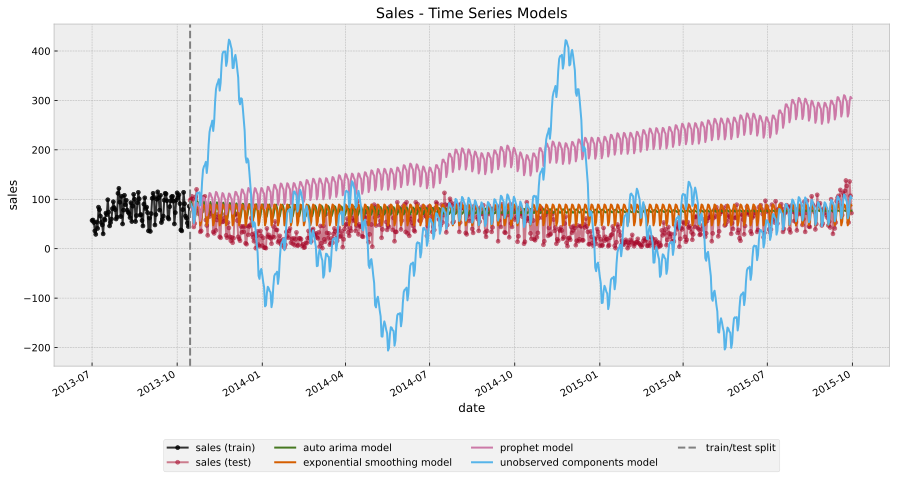

In [46]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="sales",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.5,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,
)
y_pred_arima.plot(label="auto arima model", color="C3", ax=ax)
y_pred_es.plot(label="exponential smoothing model", color="C4", ax=ax)
y_pred_p.plot(label="prophet model", color="C5", ax=ax)
y_pred_uc.plot(label="unobserved components model", color="C6", ax=ax)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=4)
ax.set(title="Sales - Time Series Models");

None of them capture both the short and long term seasonality (of course! there is simply not enough data!).